In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashmotiani/dogs-skin-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/yashmotiani/dogs-skin-disease-dataset/versions/1


In [2]:
!kaggle datasets download yashmotiani/dogs-skin-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/yashmotiani/dogs-skin-disease-dataset
License(s): CC0-1.0
dogs-skin-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip dogs-skin-disease-dataset.zip -d /content/dataset

Archive:  dogs-skin-disease-dataset.zip
replace /content/dataset/Dogs/Bacterial_dermatosis/453.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import matplotlib.pyplot as plt # Importing the pyplot module from matplotlib and aliasing it as plt
import os
import cv2
import numpy as np

In [7]:
#function to load the images and their corresponding labels
def load_images_from_folder(folder):
    images = []
    labels = []

    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        #print (image_path)
        parts = image_name.split('-')
        disease_name = parts[0]

        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (299, 299))
            image = image.astype(np.float32) / 255.0

            images.append(image)
            labels.append(disease_name)

    return images, labels

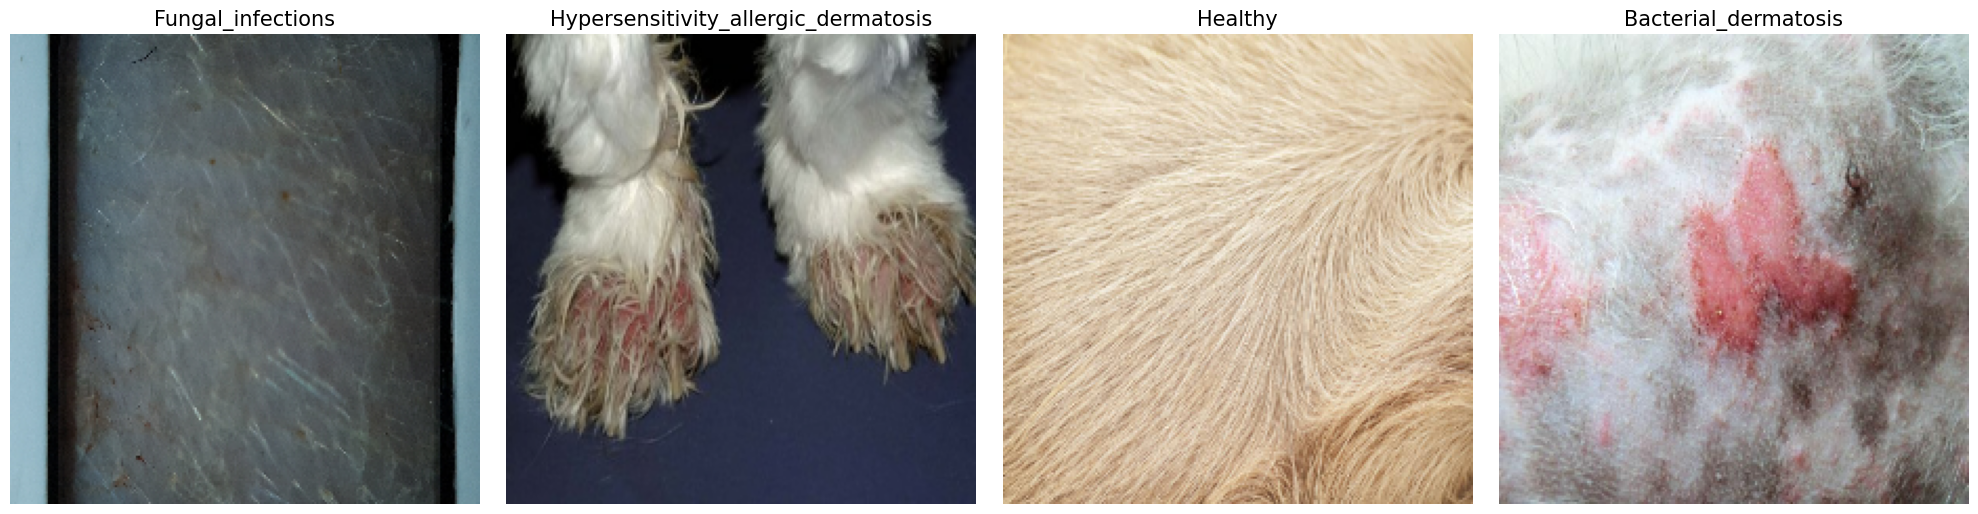

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

dataset_path = "/content/dataset/Dogs"

def load_balanced_sample_images(folder_path, img_size=(224, 224), num_samples=5):
    class_names = os.listdir(folder_path)
    random.shuffle(class_names)  # สลับลำดับคลาสแบบสุ่ม

    images = []
    labels = []

    selected_classes = random.sample(class_names, min(num_samples, len(class_names)))  # สุ่มเลือก class

    for class_name in selected_classes:
        class_path = os.path.join(folder_path, class_name)
        image_files = os.listdir(class_path)
        random.shuffle(image_files)  # สลับลำดับไฟล์ภาพภายในคลาส

        selected_images = random.sample(image_files, min(1, len(image_files)))  # ดึงภาพละ 1 รูปจากแต่ละคลาส

        for img_file in selected_images:
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, img_size)
                images.append(image)
                labels.append(class_name)

    return images, labels

# โหลดภาพใหม่
sample_images, sample_labels = load_balanced_sample_images(dataset_path)

# แสดงภาพใหม่
fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.set_title(sample_labels[i], fontsize=15)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
pip install split-folders

In [10]:
import splitfolders

# Path ของ dataset เดิม
input_folder = "dataset/Dogs"

# Path ของ dataset ที่แบ่งแล้ว
output_folder = "dataset_split"

# แบ่งเป็น 70% Train, 20% Validation, 10% Test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 443 files [00:01, 230.51 files/s]


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ของชุดข้อมูลที่แบ่งแล้ว
train_path = "dataset_split/train"
val_path = "dataset_split/val"
test_path = "dataset_split/test"

# Data Augmentation สำหรับ Train Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True
)

# โหลด Train Set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# โหลด Validation Set
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# โหลด Test Set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # ห้าม shuffle test set
)

Found 303 images belonging to 4 classes.
Found 87 images belonging to 4 classes.
Found 49 images belonging to 4 classes.


In [12]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# ✅ โหลด EfficientNetB3 พร้อม Weights ที่ Pre-trained จาก ImageNet
base_model = EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-Tune ได้

# ✅ ปลดล็อกแค่ Layer 30+ เพื่อให้ Fine-Tune ได้แต่ไม่ Overfit
for layer in base_model.layers[:30]:
    layer.trainable = False

# ✅ นับจำนวนคลาสใน Dataset
num_classes = len(train_generator.class_indices)

# ✅ สร้างโมเดล CNN-based ใหม่
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

# ✅ คอมไพล์โมเดล
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

# ✅ โหลดข้อมูลใหม่ด้วย Augmentation
train_generator = train_datagen.flow_from_directory("/content/dataset_split/train", target_size=(224, 224), batch_size=32, class_mode="categorical")
val_generator = val_datagen.flow_from_directory("/content/dataset_split/val", target_size=(224, 224), batch_size=32, class_mode="categorical")

# ✅ ตั้งค่า Early Stopping และ Save Best Model
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# ✅ ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint]
)

# ✅ โหลดโมเดลที่ดีที่สุด
model = tf.keras.models.load_model("best_model.h5")

Found 303 images belonging to 4 classes.
Found 87 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2758 - loss: 2.8601
Epoch 1: val_loss improved from inf to 1.92098, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.2756 - loss: 2.8521 - val_accuracy: 0.3218 - val_loss: 1.9210
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.3654 - loss: 2.2918
Epoch 2: val_loss improved from 1.92098 to 1.88386, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 871ms/step - accuracy: 0.3673 - loss: 2.2943 - val_accuracy: 0.3448 - val_loss: 1.8839
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.4129 - loss: 2.0593
Epoch 3: val_loss improved from 1.88386 to 1.85650, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 962ms/step - accuracy: 0.4186 - loss: 2.0590 - val_accuracy: 0.3678 - val_loss: 1.8565
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.4938 - loss: 2.0409
Epoch 4: val_loss improved from 1.85650 to 1.83326, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 967ms/step - accuracy: 0.4939 - loss: 2.0402 - val_accuracy: 0.4253 - val_loss: 1.8333
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5171 - loss: 1.9451
Epoch 5: val_loss improved from 1.83326 to 1.80912, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 956ms/step - accuracy: 0.5178 - loss: 1.9449 - val_accuracy: 0.4253 - val_loss: 1.8091
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.5826 - loss: 1.6766
Epoch 6: val_loss improved from 1.80912 to 1.78767, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 891ms/step - accuracy: 0.5836 - loss: 1.6751 - val_accuracy: 0.4368 - val_loss: 1.7877
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5587 - loss: 1.7959
Epoch 7: val_loss improved from 1.78767 to 1.75822, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 968ms/step - accuracy: 0.5607 - loss: 1.7923 - val_accuracy: 0.4713 - val_loss: 1.7582
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.6426 - loss: 1.4762
Epoch 8: val_loss improved from 1.75822 to 1.73043, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 992ms/step - accuracy: 0.6457 - loss: 1.4716 - val_accuracy: 0.5287 - val_loss: 1.7304
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.6636 - loss: 1.4000
Epoch 9: val_loss improved from 1.73043 to 1.70510, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 957ms/step - accuracy: 0.6666 - loss: 1.3955 - val_accuracy: 0.5172 - val_loss: 1.7051
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.7359 - loss: 1.2553
Epoch 10: val_loss improved from 1.70510 to 1.68994, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 927ms/step - accuracy: 0.7365 - loss: 1.2591 - val_accuracy: 0.5057 - val_loss: 1.6899
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7332 - loss: 1.3867
Epoch 11: val_loss improved from 1.68994 to 1.65631, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 876ms/step - accuracy: 0.7320 - loss: 1.3855 - val_accuracy: 0.5172 - val_loss: 1.6563
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.7724 - loss: 1.1210
Epoch 12: val_loss improved from 1.65631 to 1.62951, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 973ms/step - accuracy: 0.7718 - loss: 1.1258 - val_accuracy: 0.5862 - val_loss: 1.6295
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7746 - loss: 1.2495
Epoch 13: val_loss improved from 1.62951 to 1.58541, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 982ms/step - accuracy: 0.7714 - loss: 1.2558 - val_accuracy: 0.5977 - val_loss: 1.5854
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7876 - loss: 1.1186
Epoch 14: val_loss improved from 1.58541 to 1.54647, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 964ms/step - accuracy: 0.7889 - loss: 1.1130 - val_accuracy: 0.6092 - val_loss: 1.5465
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.7594 - loss: 1.1649
Epoch 15: val_loss improved from 1.54647 to 1.51518, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 889ms/step - accuracy: 0.7618 - loss: 1.1578 - val_accuracy: 0.6667 - val_loss: 1.5152
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8192 - loss: 1.0051
Epoch 16: val_loss improved from 1.51518 to 1.49511, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8215 - loss: 1.0033 - val_accuracy: 0.6782 - val_loss: 1.4951
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.8225 - loss: 1.0921
Epoch 17: val_loss did not improve from 1.49511
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 922ms/step - accuracy: 0.8237 - loss: 1.0892 - val_accuracy: 0.6207 - val_loss: 1.5657
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8557 - loss: 0.9186
Epoch 18: val_loss did not improve from 1.49511
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 868ms/step - accuracy: 0.8542 - loss: 0.9199 - val_accuracy: 0.6667 - val_loss: 1.5444
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8658 - loss: 0.8691
Epoch 19: val_loss did not improve from 1.49511
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - accuracy: 0.8654 - loss: 0.8722 - val_accuracy: 0.6322 - val_loss: 1.5616
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8854 - loss: 0.8796
Epoch 20: val_loss did not improve from 1.

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 971ms/step - accuracy: 0.8873 - loss: 0.9132 - val_accuracy: 0.6897 - val_loss: 1.4300
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9171 - loss: 0.8016
Epoch 25: val_loss improved from 1.42996 to 1.37019, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 945ms/step - accuracy: 0.9154 - loss: 0.8014 - val_accuracy: 0.6667 - val_loss: 1.3702
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8758 - loss: 0.8593
Epoch 26: val_loss did not improve from 1.37019
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 746ms/step - accuracy: 0.8766 - loss: 0.8580 - val_accuracy: 0.6782 - val_loss: 1.3908
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.9089 - loss: 0.8604
Epoch 27: val_loss did not improve from 1.37019
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 883ms/step - accuracy: 0.9115 - loss: 0.8515 - val_accuracy: 0.6782 - val_loss: 1.5061
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9015 - loss: 0.8009
Epoch 28: val_loss did not improve from 1.37019
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step - accuracy: 0.9027 - loss: 0.8006 - val_accuracy: 0.6322 - val_loss: 1.5647
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9254 - loss: 0.7849
Epoch 29: val_loss did not improve from 

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 941ms/step - accuracy: 0.9416 - loss: 0.6703 - val_accuracy: 0.7356 - val_loss: 1.3598
Epoch 43/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9771 - loss: 0.6032
Epoch 43: val_loss improved from 1.35983 to 1.32868, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.9765 - loss: 0.6046 - val_accuracy: 0.7586 - val_loss: 1.3287
Epoch 44/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9510 - loss: 0.6548
Epoch 44: val_loss did not improve from 1.32868
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 837ms/step - accuracy: 0.9510 - loss: 0.6566 - val_accuracy: 0.7586 - val_loss: 1.3607
Epoch 45/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9676 - loss: 0.6397
Epoch 45: val_loss did not improve from 1.32868
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 845ms/step - accuracy: 0.9675 - loss: 0.6417 - val_accuracy: 0.7701 - val_loss: 1.4001
Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9430 - loss: 0.6777
Epoch 46: val_loss did not improve from 1.32868
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 743ms/step - accuracy: 0.9440 - loss: 0.6756 - val_accuracy: 0.7701 - val_loss: 1.4101
Epoch 47/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9767 - loss: 0.6220
Epoch 47: val_loss did not improve from 

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os

# ✅ โหลดโมเดลที่ดีที่สุด
model = tf.keras.models.load_model("best_model.h5")

# ✅ โหลด Test Data Generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    "/content/dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# ✅ ทดสอบโมเดลกับชุดข้อมูล Test
test_loss, test_acc = model.evaluate(test_generator)
print(f"⭐ Test Accuracy: {test_acc:.4f}")
print(f"⭐ Test Loss: {test_loss:.4f}")


Found 49 images belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.6301 - loss: 1.7988
⭐ Test Accuracy: 0.6327
⭐ Test Loss: 1.7841


In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_disease(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_names = ["Bacterial Dermatosis", "Fungal Infection", "Hypersensitivity Dermatitis", "Healthy"]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100  # เปลี่ยนเป็น %

    return f"{predicted_class} (Confidence: {confidence:.2f}%)"

# ทดสอบกับภาพจริง
test_img = "/content/dataset_split/test/Hypersensitivity_allergic_dermatosis/pic1.jpg"
result = predict_disease(test_img, model)
print(f"🔹 Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
🔹 Prediction: Hypersensitivity Dermatitis (Confidence: 87.35%)


In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"🔹 Test Accuracy: {test_acc:.4f}")
print(f"🔹 Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6886 - loss: 1.4342
🔹 Test Accuracy: 0.6735
🔹 Test Loss: 1.4696


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


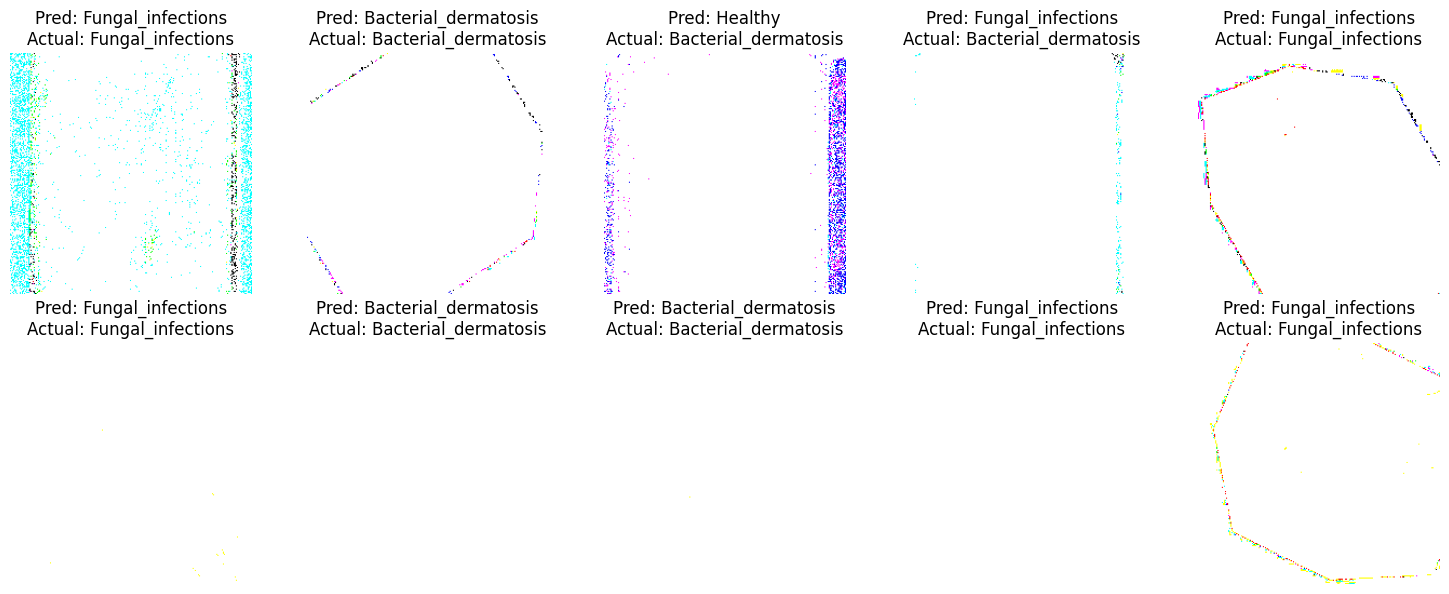

In [15]:
import random
import matplotlib.pyplot as plt

# เลือกรูปแบบสุ่มจาก Test Set
test_images, test_labels = next(test_generator)
random_indices = random.sample(range(len(test_images)), 10)  # สุ่ม 10 รูป

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = test_images[idx]

    # ทำนายผล
    prediction = model.predict(np.expand_dims(img, axis=0))
    class_names = list(test_generator.class_indices.keys())
    predicted_label = class_names[np.argmax(prediction)]

    # แสดงภาพ
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_label}\nActual: {class_names[np.argmax(test_labels[idx])]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


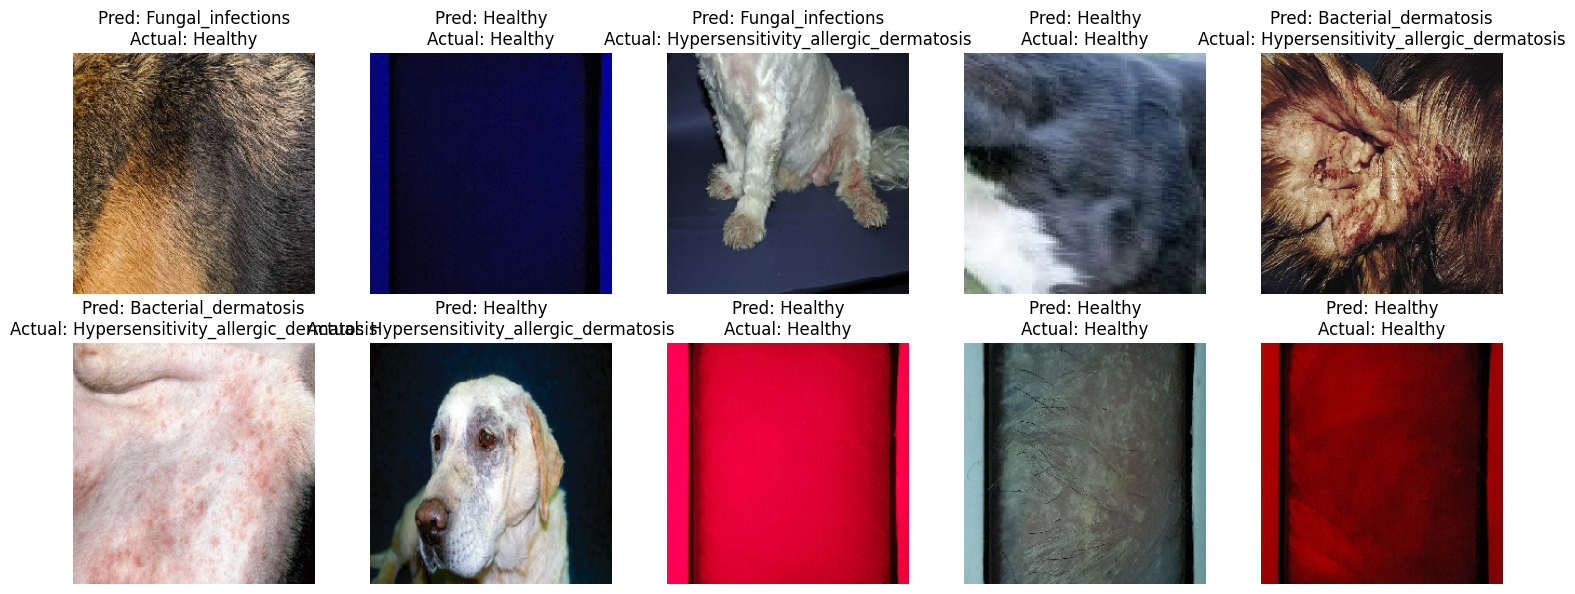

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ดึงข้อมูลจาก Test Generator
test_images, test_labels = next(test_generator)
random_indices = random.sample(range(len(test_images)), 10)  # สุ่ม 10 รูป

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img = test_images[idx]

    # 🔹 แปลงค่าให้อยู่ในช่วง [0, 255] และใช้ dtype เป็น uint8
    if img.max() <= 1.0:
        img_display = (img * 255).astype(np.uint8)  # แปลงเป็น uint8
    else:
        img_display = img.astype(np.uint8)

    # 🔹 ทำนายผล
    prediction = model.predict(np.expand_dims(img, axis=0))  # **ไม่ Normalize ซ้ำ**
    class_names = list(test_generator.class_indices.keys())
    predicted_label = class_names[np.argmax(prediction)]
    actual_label = class_names[np.argmax(test_labels[idx])]

    # 🔹 แสดงภาพ
    ax.imshow(img_display)  # ใช้ภาพที่ถูก Normalize กลับมาแล้ว
    ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [17]:
pip install mlflow

In [2]:
import mlflow
import mlflow.tensorflow

In [14]:
# ✅ กำหนด MLflow Tracking URI

URL_MLFLOW = "http://34.87.66.93:5000"

mlflow.set_experiment("Detection")
mlflow.set_tracking_uri(URL_MLFLOW)

# ✅ โหลดโมเดลที่ดีที่สุด
model = tf.keras.models.load_model("best_model.h5")

# ✅ เริ่ม MLflow run
with mlflow.start_run():
    # บันทึก Parameters
    mlflow.log_params({
        "learning_rate": 0.0002,
        "optimizer": "Adam",
        "batch_size": 32,
        "epochs": 50,
        "base_model": "EfficientNetB3"
    })

    # บันทึก Metrics
    mlflow.log_metrics({
        'accuracy': history.history['accuracy'][-1],  # Accuracy ล่าสุด
        'val_accuracy': history.history['val_accuracy'][-1],
        'loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1]
    })

    # ✅ บันทึกโมเดลไปยัง MLflow
    mlflow.tensorflow.log_model(model, artifact_path="EfficientNetB3")


2025/03/11 15:40:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/11 15:40:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run languid-hare-182 at: http://34.87.66.93:5000/#/experiments/991795900380600050/runs/bce75920e75645eb8c65dd5632e6d471
🧪 View experiment at: http://34.87.66.93:5000/#/experiments/991795900380600050
